In [1]:
!pip install tensorflow-addons

In [2]:
# Import the libraries
import os
import numpy as np
from numpy import load
from scipy.sparse import load_npz
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, PrecisionAtRecall
from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt

In [3]:
# Check that a GPU is available
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Not sure why, but I need this to get TF to work
# from: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Enable mixed precision training
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

### Load in the data

In [6]:
# Define the load path
load_path = '../Datasets/AmazonCat-13K/processed/'

In [7]:
# Load the X_train
X_train_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_train.npz')
X_train = X_train_data['arr_0']

In [8]:
# Load the X_test
X_test_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_test.npz')
X_test = X_test_data['arr_0']

In [9]:
# Load y_train
y_train_sparse = load_npz(load_path + 'y_train_sparse.npz').astype('int64')

In [10]:
# Load y_test
y_test_sparse = load_npz(load_path + 'y_test_sparse.npz').astype('int64')

In [11]:
# Check the shape of the X data
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (1120773, 512)
X_test: (373591, 512)


In [12]:
# Check the shape of the X data
print(f'y_train: {y_train_sparse.shape}')
print(f'y_test: {y_test_sparse.shape}')

y_train: (1120773, 14295)
y_test: (373591, 14295)


### Create Sparse Tensors

In [13]:
# Create function to convert sparse matrix to SparseTensor
def convert_sparse_matrix_to_sparse_tensor(sparse_matrix):
    coo = sparse_matrix.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [14]:
# Create sparse tensor of y_train
y_train_sparse_tensor = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(y_train_sparse))

In [15]:
# Create sparse tensor of y_test
y_test_sparse_tensor = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(y_test_sparse))

### Create the TensorFlow Dataset

In [16]:
# Create function to convert SparseTensor to dense tensor
def convert_sparse_tensor_to_dense_tensor(X, y_sparse):
    y_dense = tf.sparse.to_dense(y_sparse)
    return X, y_dense

In [17]:
tr_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_sparse_tensor))
tr_dataset = tr_dataset.map(convert_sparse_tensor_to_dense_tensor)
tr_dataset = tr_dataset.batch(batch_size=1024)

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_sparse_tensor))
val_dataset = val_dataset.map(convert_sparse_tensor_to_dense_tensor)
val_dataset = val_dataset.batch(batch_size=1024)

### Create the embedding layer

In [19]:
# Create the embedding layer definition
class PretrainedEmbedding(tf.keras.layers.Layer):
    """Non-trainable embedding layer."""

    def __init__(self, embeddings, dropout_rate=0.2, **kwargs):
        """"Instantiate the layer using a pre-defined embedding matrix."""
        super().__init__(**kwargs)
        self.embeddings = tf.constant(embeddings)
        # if you want to add some dropout (or normalization, etc.)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, inputs, training=None):
        """Embed some input tokens and optionally apply dropout."""
        output = tf.nn.embedding_lookup(self.embeddings, inputs)
        return self.dropout(output, training=training)

In [20]:
# Load in the embedding matrix
embedding_matrix = np.loadtxt(load_path + 'embedding_matrix.csv', delimiter=',')

In [21]:
# Check the embedding matrix size
embedding_matrix.shape

(200000, 200)

### Define the model layers

In [22]:
# Define the Input and Embedding layers
i = Input(shape=(X_train.shape[1]), dtype=tf.int32)
x = PretrainedEmbedding(embedding_matrix, dropout_rate=0)(i)

# Convolution with window size = 3  
x3 = Conv1D(filters=96, 
            kernel_size=3, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x3 = GlobalMaxPooling1D()(x3)

# Convolution with window size = 4
x4 = Conv1D(filters=96, 
            kernel_size=4, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x4 = GlobalMaxPooling1D()(x4)

# Convolution with window size = 5
x5 = Conv1D(filters=96, 
            kernel_size=5, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x5 = GlobalMaxPooling1D()(x5)

# Concatenated max-pooling layers with Dropout (CNN-Kim uses a dropout rate of 0.5)
concatenated = concatenate([x3, x4, x5])
x = Dropout(rate=0.5)(concatenated)

# Final, fully-connected Dense layer
x = Dense(y_train_sparse.shape[1], activation='sigmoid')(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [23]:
# Build the model
model = Model(i, x)

In [24]:
# Remove unused vars (to save memory)
del embedding_matrix

In [25]:
# Have a look at the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
pretrained_embedding (Pretraine (None, 512, 200)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 510, 96)      57696       pretrained_embedding[0][0]       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 509, 96)      76896       pretrained_embedding[0][0]       
______________________________________________________________________________________________

### Define how the model should be trained

In [26]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.025), # CNN-Kim uses SGD with Adelta update rule
              loss='binary_crossentropy',
              metrics=[Recall(name='Recall'),
                       PrecisionAtRecall(0.365),
                       Precision(top_k=1, name='PrecisionAt1'),
                       Precision(top_k=3, name='PrecisionAt3'),
                       Precision(top_k=5, name='PrecisionAt5'),
                       Precision(top_k=10, name='PrecisionAt10'),
                       F1Score(num_classes=y_train_sparse.shape[1], 
                               average='micro', 
                               threshold=0.5,
                               name='MicroF1'),
                       F1Score(num_classes=y_train_sparse.shape[1], 
                               average='macro', 
                               threshold=0.5,
                               name='MacroF1'),
                       F1Score(num_classes=y_train_sparse.shape[1], 
                               average='weighted', 
                               threshold=0.5,
                               name='WeightedF1')])

In [27]:
# Create learning rate decay function
def lr_scheduler(epoch, lr):
    learning_rate = lr * 0.9
    print(f'Learning Rate: {learning_rate}')
    return learning_rate

# define the learning rate scheduler
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Train the model

In [28]:
# Train the model
result = model.fit(tr_dataset,
                   epochs=75,
                   validation_data=val_dataset,
                   callbacks=[callback]);

Train for 1095 steps, validate for 365 steps
Learning Rate: 0.02250000033527613
Epoch 1/75
1095/1095 [==============================] - 366s 335ms/step - loss: 0.0064 - Recall: 0.1267 - PrecisionAt1: 0.5231 - PrecisionAt3: 0.3220 - PrecisionAt5: 0.2397 - PrecisionAt10: 0.1544 - MicroF1: 0.0988 - MacroF1: 0.0019 - WeightedF1: 0.1546 - val_loss: 0.0030 - val_Recall: 0.1803 - val_PrecisionAt1: 0.7386 - val_PrecisionAt3: 0.4687 - val_PrecisionAt5: 0.3323 - val_PrecisionAt10: 0.2036 - val_MicroF1: 0.2941 - val_MacroF1: 0.0025 - val_WeightedF1: 0.2063
Learning Rate: 0.020250000804662705
Epoch 2/75
1095/1095 [==============================] - 358s 327ms/step - loss: 0.0026 - Recall: 0.2132 - PrecisionAt1: 0.6777 - PrecisionAt3: 0.4331 - PrecisionAt5: 0.3199 - PrecisionAt10: 0.2011 - MicroF1: 0.3034 - MacroF1: 0.0071 - WeightedF1: 0.2520 - val_loss: 0.0019 - val_Recall: 0.2057 - val_PrecisionAt1: 0.7975 - val_PrecisionAt3: 0.5465 - val_PrecisionAt5: 0.4002 - val_PrecisionAt10: 0.2474 - val_Mic

1095/1095 [==============================] - 356s 325ms/step - loss: 0.0012 - Recall: 0.3250 - PrecisionAt1: 0.8304 - PrecisionAt3: 0.6134 - PrecisionAt5: 0.4690 - PrecisionAt10: 0.2936 - MicroF1: 0.4495 - MacroF1: 0.0695 - WeightedF1: 0.3915 - val_loss: 0.0010 - val_Recall: 0.3215 - val_PrecisionAt1: 0.8792 - val_PrecisionAt3: 0.6741 - val_PrecisionAt5: 0.5197 - val_PrecisionAt10: 0.3222 - val_MicroF1: 0.4693 - val_MacroF1: 0.0469 - val_WeightedF1: 0.3874
Learning Rate: 0.0037523651495575904
Epoch 18/75
1095/1095 [==============================] - 356s 325ms/step - loss: 0.0012 - Recall: 0.3298 - PrecisionAt1: 0.8340 - PrecisionAt3: 0.6185 - PrecisionAt5: 0.4738 - PrecisionAt10: 0.2967 - MicroF1: 0.4549 - MacroF1: 0.0745 - WeightedF1: 0.3970 - val_loss: 0.0010 - val_Recall: 0.3189 - val_PrecisionAt1: 0.8791 - val_PrecisionAt3: 0.6770 - val_PrecisionAt5: 0.5233 - val_PrecisionAt10: 0.3246 - val_MicroF1: 0.4677 - val_MacroF1: 0.0512 - val_WeightedF1: 0.3849
Learning Rate: 0.003377128718

1095/1095 [==============================] - 357s 326ms/step - loss: 0.0010 - Recall: 0.3699 - PrecisionAt1: 0.8646 - PrecisionAt3: 0.6620 - PrecisionAt5: 0.5145 - PrecisionAt10: 0.3220 - MicroF1: 0.4997 - MacroF1: 0.1330 - WeightedF1: 0.4425 - val_loss: 9.1587e-04 - val_Recall: 0.3621 - val_PrecisionAt1: 0.8960 - val_PrecisionAt3: 0.7034 - val_PrecisionAt5: 0.5509 - val_PrecisionAt10: 0.3415 - val_MicroF1: 0.5119 - val_MacroF1: 0.0803 - val_WeightedF1: 0.4340
Learning Rate: 0.000695320829981938
Epoch 34/75
1095/1095 [==============================] - 357s 326ms/step - loss: 9.9614e-04 - Recall: 0.3709 - PrecisionAt1: 0.8658 - PrecisionAt3: 0.6633 - PrecisionAt5: 0.5155 - PrecisionAt10: 0.3227 - MicroF1: 0.5008 - MacroF1: 0.1359 - WeightedF1: 0.4436 - val_loss: 9.1427e-04 - val_Recall: 0.3612 - val_PrecisionAt1: 0.8964 - val_PrecisionAt3: 0.7040 - val_PrecisionAt5: 0.5516 - val_PrecisionAt10: 0.3421 - val_MicroF1: 0.5113 - val_MacroF1: 0.0818 - val_WeightedF1: 0.4334
Learning Rate: 0.0

Learning Rate: 0.0001431604046956636
Epoch 49/75
1095/1095 [==============================] - 357s 326ms/step - loss: 9.6467e-04 - Recall: 0.3789 - PrecisionAt1: 0.8709 - PrecisionAt3: 0.6718 - PrecisionAt5: 0.5240 - PrecisionAt10: 0.3281 - MicroF1: 0.5097 - MacroF1: 0.1526 - WeightedF1: 0.4527 - val_loss: 9.0125e-04 - val_Recall: 0.3661 - val_PrecisionAt1: 0.8994 - val_PrecisionAt3: 0.7092 - val_PrecisionAt5: 0.5570 - val_PrecisionAt10: 0.3453 - val_MicroF1: 0.5169 - val_MacroF1: 0.0879 - val_WeightedF1: 0.4387
Learning Rate: 0.0001288443629164249
Epoch 50/75
1095/1095 [==============================] - 357s 326ms/step - loss: 9.6418e-04 - Recall: 0.3791 - PrecisionAt1: 0.8711 - PrecisionAt3: 0.6718 - PrecisionAt5: 0.5242 - PrecisionAt10: 0.3282 - MicroF1: 0.5099 - MacroF1: 0.1539 - WeightedF1: 0.4530 - val_loss: 9.0115e-04 - val_Recall: 0.3657 - val_PrecisionAt1: 0.8996 - val_PrecisionAt3: 0.7092 - val_PrecisionAt5: 0.5571 - val_PrecisionAt10: 0.3454 - val_MicroF1: 0.5166 - val_Macro

Learning Rate: 2.6527911541052162e-05
Epoch 65/75
1095/1095 [==============================] - 356s 326ms/step - loss: 9.5808e-04 - Recall: 0.3807 - PrecisionAt1: 0.8724 - PrecisionAt3: 0.6734 - PrecisionAt5: 0.5256 - PrecisionAt10: 0.3292 - MicroF1: 0.5117 - MacroF1: 0.1574 - WeightedF1: 0.4548 - val_loss: 8.9914e-04 - val_Recall: 0.3669 - val_PrecisionAt1: 0.9002 - val_PrecisionAt3: 0.7102 - val_PrecisionAt5: 0.5579 - val_PrecisionAt10: 0.3459 - val_MicroF1: 0.5178 - val_MacroF1: 0.0892 - val_WeightedF1: 0.4397
Learning Rate: 2.387512104178313e-05
Epoch 66/75
1095/1095 [==============================] - 356s 325ms/step - loss: 9.5782e-04 - Recall: 0.3807 - PrecisionAt1: 0.8723 - PrecisionAt3: 0.6734 - PrecisionAt5: 0.5256 - PrecisionAt10: 0.3292 - MicroF1: 0.5117 - MacroF1: 0.1570 - WeightedF1: 0.4548 - val_loss: 8.9907e-04 - val_Recall: 0.3668 - val_PrecisionAt1: 0.9001 - val_PrecisionAt3: 0.7103 - val_PrecisionAt5: 0.5578 - val_PrecisionAt10: 0.3459 - val_MicroF1: 0.5178 - val_Macr

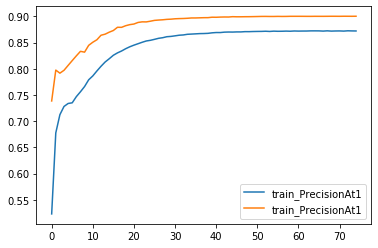

In [29]:
# Plot the PrecisionAt1 metric at each itteration
plt.plot(result.history['PrecisionAt1'], label='train_PrecisionAt1');
plt.plot(result.history['val_PrecisionAt1'], label='val_PrecisionAt1');
plt.legend();

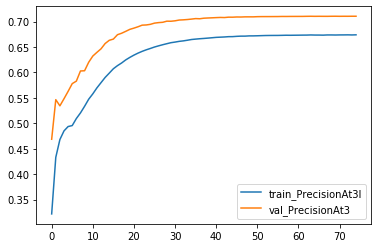

In [30]:
# Plot the PrecisionAt3 metric at each itteration
plt.plot(result.history['PrecisionAt3'], label='train_PrecisionAt3l');
plt.plot(result.history['val_PrecisionAt3'], label='val_PrecisionAt3');
plt.legend();

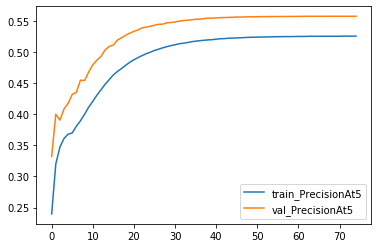

In [31]:
# Plot the PrecisionAt5 metric at each itteration
plt.plot(result.history['PrecisionAt5'], label='train_PrecisionAt5');
plt.plot(result.history['val_PrecisionAt5'], label='val_PrecisionAt5');
plt.legend();

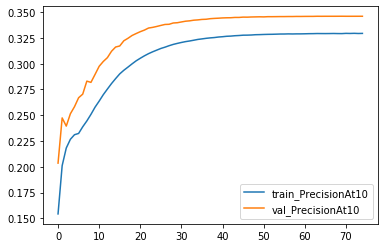

In [32]:
# Plot the PrecisionAt10 metric at each itteration
plt.plot(result.history['PrecisionAt10'], label='train_PrecisionAt10');
plt.plot(result.history['val_PrecisionAt10'], label='val_PrecisionAt10');
plt.legend();

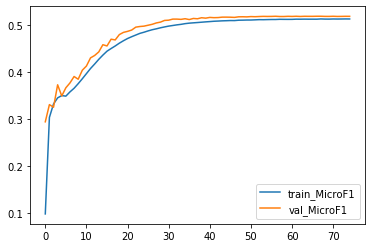

In [33]:
# Plot the MicroF1 metric at each itteration
plt.plot(result.history['MicroF1'], label='train_MicroF1');
plt.plot(result.history['val_MicroF1'], label='val_MicroF1');
plt.legend();

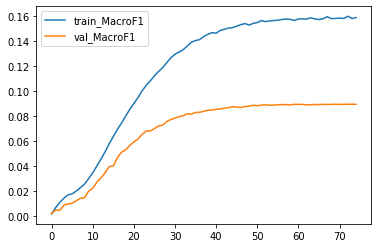

In [34]:
# Plot the MacroF1 metric at each itteration
plt.plot(result.history['MacroF1'], label='train_MacroF1');
plt.plot(result.history['val_MacroF1'], label='val_MacroF1');
plt.legend();

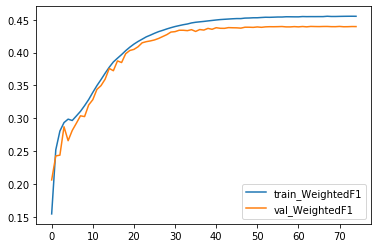

In [35]:
# Plot the WeightedF1 metric at each itteration
plt.plot(result.history['WeightedF1'], label='train_WeightedF1');
plt.plot(result.history['val_WeightedF1'], label='val_WeightedF1');
plt.legend();